In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import pandas as pd
from nltk.corpus import stopwords
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input/word2vec-nlp-tutorial/"))
# print(os.listdir("../input/movie-review/"))

# Any results you write to the current directory are saved as output.

### Input the data

In [2]:
#the file shows the fields separated by space and quoted by ", 
#and that where someone has included a quoted string in their review 
#there is a backslash before the quotes to escape them
# df1 = pd.read_csv('../input/word2vec-nlp-tutorial/labeledTrainData.tsv', delimiter="\t")

df = pd.read_csv('data.tsv', sep=' ', quotechar='"', escapechar='\\')
df.head()

,new_id,sentiment,review
0,1,1,I quite enjoyed this movie for two reasons. Th...
1,2,0,A man in blackface lands in a spaceship and me...
2,3,1,I was really beginning to enjoy this show. It ...
3,4,0,It is one of the joys of Shakespeare that ther...
4,5,0,I am a big fan of Stephen King. I loved The Ru...


In [3]:
# Split the data into training and testing set based on the splits,csv file
# Each column consist of 25,000 test samples ID, so we can separate the data into three different train/test samples
# split = pd.read_csv('../input/project4/splits.csv', sep='\t', quotechar='"', escapechar='\\')
# split.head(3)
split = pd.read_csv('splits.csv', sep='\t', quotechar='"', escapechar='\\')
split.head()


,split_1,split_2,split_3
0,2,9245,8403
1,3,35118,40376
2,4,28666,19247
3,8,8403,16386
4,13,47189,30103


### Generate vocabulary list

In [4]:
from bs4 import BeautifulSoup
def review_to_words( raw_review ):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'lxml').get_text() 
    
    # 2. Remove non-letters with regex
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                           
    
    # 4. Create set of stopwords
    stops = set(stopwords.words("english"))                  
    
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   


In [5]:
# # Get the vocabulary list (<= 5000 )
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

df['review']=df['review'].apply(review_to_words)
list_sentences_whole_train = df["review"]

max_features = 5000
tokenizer = Tokenizer(oov_token = 'UNK',num_words=max_features)

#Fit the tokenizer using the whole training data
tokenizer.fit_on_texts(list(list_sentences_whole_train))
list_tokenized_whole_train = tokenizer.texts_to_sequences(list_sentences_whole_train)


#https://github.com/keras-team/keras/issues/8092#issuecomment-372833486
#Becasue we want to restrict the 
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= 4999} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_features
vocabulary = [k for k in tokenizer.word_index.keys()]

print("Vocabulary length is {0}".format(len(vocabulary)))

outF = open("myVocab.txt", "w")
for i in vocabulary:
    outF.write(i)
    outF.write(",")

Using TensorFlow backend.


Vocabulary length is 5000


### Words distribution graph based on vocabulary list

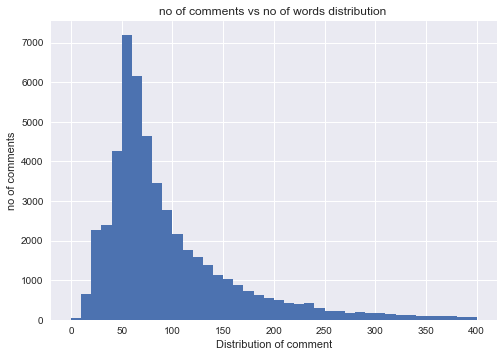

In [6]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_whole_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.xlabel("Distribution of comment")
plt.ylabel("no of comments")
plt.title("no of comments vs no of words distribution ")
plt.show()

### Data Preprocessing

In [7]:
# Select s to determine which train and test split (S = 1 or 2 or 3)
s = 1

train_list = []
test_list  = []
# Use left join to seperate our data 
test1 = df.merge(split[['split_1']], left_on='new_id', right_on='split_1', how='inner')
test1 = test1.drop('split_1',axis = 1)
test1 = test1.reset_index(drop=True)

#Select the rows not in test1 id
train1 = df.loc[~df['new_id'].isin(test1['new_id'])]
train1 = train1.reset_index(drop=True)

# Use left join to seperate our data 
test2 = df.merge(split[['split_2']], left_on='new_id', right_on='split_2', how='inner')
test2 = test2.drop('split_2',axis = 1)
test2 = test2.reset_index(drop=True)

#Select the rows not in test1 id
train2 = df.loc[~df['new_id'].isin(test2['new_id'])]
train2 = train2.reset_index(drop=True)

# Use left join to seperate our data 
test3 = df.merge(split[['split_3']], left_on='new_id', right_on='split_3', how='inner')
test3 = test3.drop('split_3',axis = 1)
test3 = test3.reset_index(drop=True)

#Select the rows not in test1 id
train3 = df.loc[~df['new_id'].isin(test3['new_id'])]
train3 = train3.reset_index(drop=True)

train_list.append(train1)
train_list.append(train2)
train_list.append(train3)

test_list.append(test1)
test_list.append(test2)
test_list.append(test3)

train = train_list[s-1]
test = test_list[s-1]

### Display word cloud

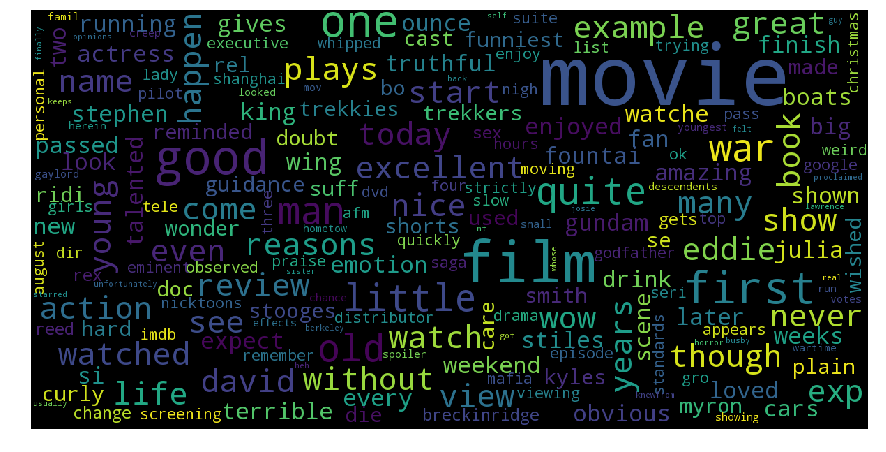

In [8]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train["review"])

### Do the text processing, convert word vector and fit LSTM model

In [9]:
from nltk.corpus import stopwords
model_list = []

# for train, test in zip(train_list,test_list):
train['review']=train['review'].apply(review_to_words)
test["review"]=test["review"].apply(review_to_words)

#     # checking nullity in the data of train and test
#     print(test.isnull().sum())

list_classes = ["sentiment"]
y = train[list_classes].values

list_sentences_train = train["review"]
list_sentences_test = test["review"]

max_features = 5000
# tokenizer = Tokenizer(oov_token = 'UNK',num_words=max_features)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

maxlen = 370
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
result = model.predict(X_te)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 394s 20ms/step - loss: 0.3859 - acc: 0.8284 - val_loss: 0.3047 - val_acc: 0.8770
Epoch 2/2
20000/20000 [==============================] - 349s 17ms/step - loss: 0.2350 - acc: 0.9076 - val_loss: 0.3055 - val_acc: 0.8738


### Save the prob (sentiment = 1) result in mysubmission.txt

In [10]:
result_ = [result[i][0] for i in range(len(result))]
test['new_id'].tolist()
d = {'ID':test['new_id'],'Prob':result_}
dataframe = pd.DataFrame(data=d)
np.savetxt('mysubmission.txt', dataframe, delimiter=',', header = "new_id,Prob", fmt = ['%d','%f']) 

In [11]:
from sklearn.metrics import roc_auc_score
y_true = np.array(test['sentiment'])
y_scores = result
print("ROC score is {0}".format(roc_auc_score(y_true, y_scores)))

ROC score is 0.9389123968000002


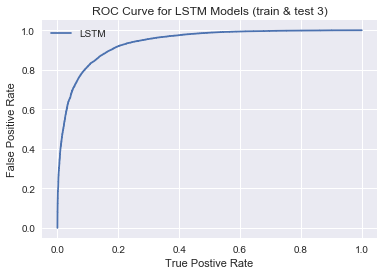

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_list = [y_scores]
label_list = ["LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for LSTM Models (train & test 1)")
plt.legend()
plt.show()